# Разглеждане на данните, трениране на модел и оптимизиране

Тук ще опитаме да видим малко "machine learning на практика". Ще разгледаме набор от данни от Kaggle, ще си поиграем с него и ще се опитаме да направим регресор, който да вади добри резултати. Идеята е да видим как изглежда процеса на решаване на реален проблем.

Целите днес: 
- да разгледаме данни от Kaggle състезание
- четене, разучаване и обработка на данни с `pandas`
- графики, описващи данните на `seaborn`
- създаване на базов (*baseline*) модел и итеративното му подобряване

Нека да започнем с малко библиотеки:

In [1]:
import sys
import numpy as np
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

Може да изтеглите данните, с които ще работим, от тук:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Трябат ви поне `train.csv` и `test.csv`, които да поставите в `data/house-prices` спрямо директорията в която е notebook-а.

### Да заредим данните и да погледнем какво имаме:

In [4]:
import os 
os.listdir('data')

['data_description.txt',
 'house-prices-advanced-regression-techniques.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [5]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

Нека да видим каква е формата на данните. Атрибутът `shape` връща размерността на данните (редове и колони).

In [6]:
print('train:', train.shape)
print('test:', test.shape)

train: (1460, 80)
test: (1459, 79)


В test има една колона по-малко. Нека да видим коя е:

In [7]:
print('missing column:', set(train.columns) - set(test.columns))

missing column: {'SalePrice'}


Ще работим с трейн сета. С тестовия няма какво да правим, защото липсва колоната, която предсказваме.

In [8]:
del test
# Това го нямаше на python лекцията. Помага да осовобидм памет, когато ни е нужна. Без да убиваме процеса.

## Проучване (разглеждане) на данните (data exploration)

Ще се опитаме да разберем какво има в предоставените данни. Ще започнем с тренировъчното множество.

In [9]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Има и файл с обяснения за всяка колона:

In [11]:
# Linux 
#!head -25 data/house-prices/data_description.txt

# The pythonic way 
train_file_path = "data/house-prices/data_description.txt"
with open(train_file_path) as f:
    for _ in range(10): # first 10 lines
        print(f.readline())

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES



Може да видим статистика какви стойности има в дадена колона и разпределението им с pandas метода `value_counts()`.

С параметъра `normalize=True` можем да гледаме данните и като проценти.

In [12]:
print(train.LandContour.value_counts())

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


In [13]:
print(train.LandContour.value_counts(normalize=True))

Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64


In [14]:
print(train.Electrical.value_counts())

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


In [15]:
print(train.Alley.value_counts())

Grvl    50
Pave    41
Name: Alley, dtype: int64


In [16]:
print(train.FullBath.value_counts())

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64


`Pandas` може да показва и графики:

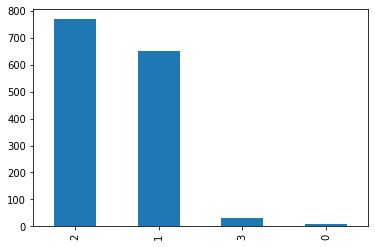

In [17]:
train.FullBath.value_counts().plot(kind='bar');

### Какво ще предсказваме - Цена на имот

Да погледнем какво разпределение имат данните.

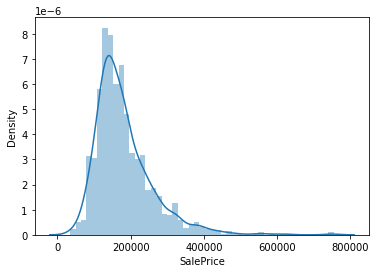

In [19]:
sns.distplot(train.SalePrice);

Ще започнем с базов (*baseline*) модел. Идеята е възможно най-бързо да намерим отправна точка, която да подобряваме.

Първо трябва да разделим данните на `x_train`, `y_train`, `x_test` и `y_test` за да проверим дали моделът генерализира.

In [20]:
from sklearn.model_selection import train_test_split

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.3, 
                                                    random_state=4330)

Дали не сме забравили какво връща `train_test_split`? Нека видим какви размери имат новите променливи:

In [21]:
for df in [x_train, x_test, y_train, y_test]:
    print(df.shape)

(1022, 79)
(438, 79)
(1022,)
(438,)


Нека започнем с линейна регресия:

In [22]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(x_train, y_train)

ValueError: could not convert string to float: 'RM'

Проблемът е, че не можем директно да вкараме текстови стойности в модела.

Как най-лесно да вземем всички числови стойности? `pandas` има метод `describe()`, който показва статистика за колоните с числови стойности.

In [219]:
x_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1022.000000,851.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1018.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,973.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,58.414873,70.177438,10735.380626,6.073386,5.545988,1971.486301,1984.690802,105.416503,443.613503,45.534247,573.775930,1062.923679,1163.329746,348.274951,5.100783,1516.705479,0.404110,0.055773,1.576321,0.366928,2.853229,1.048924,6.522505,0.607632,1978.700925,1.776908,478.014677,91.718200,48.040117,21.546967,3.934442,14.780822,3.440313,39.080235,6.277886,2007.829746
std,44.416250,26.131482,11344.844137,1.373991,1.096401,30.262989,20.737629,181.973221,464.425961,155.139109,445.058138,447.587824,392.060942,437.429167,44.532534,527.776850,0.516242,0.233822,0.548836,0.494239,0.844400,0.229025,1.646824,0.642641,24.529523,0.733376,212.612947,125.674902,68.896801,58.997097,32.831010,55.423160,45.265717,335.892594,2.731375,1.333798
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7564.250000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,229.250000,796.000000,888.000000,0.000000,0.000000,1125.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,338.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,70.000000,9544.500000,6.000000,5.000000,1972.500000,1993.500000,0.000000,380.500000,0.000000,485.000000,995.000000,1080.000000,0.000000,0.000000,1466.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2001.000000,2004.000000,168.750000,719.750000,0.000000,813.500000,1299.750000,1390.500000,729.000000,0.000000,1786.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2153.000000,6110.000000,4692.000000,2065.000000,528.000000,5642.000000,2.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,318.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000


Може да конфигурираме pandas да показва повече колони и редове:

In [23]:
pd.options.display.max_columns = 36
pd.options.display.max_rows = 10

Ще вземем числовите колони по относително мързелив начин, ползвайки резултата от `describe`:

In [24]:
numeric_column_names = x_train.describe().columns
print(numeric_column_names)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


Да опитаме отново: 

In [25]:
regressor.fit(x_train[numeric_column_names], y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Е, нали ML беше лесен, хвърлям данните на модела или невронната мрежа и готово.

Ще подълбаем още, за да открием модела:

In [26]:
x_train[numeric_column_names].isnull().sum().sort_values()

MSSubClass        0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
               ... 
BsmtFinSF2        0
YrSold            0
MasVnrArea        4
GarageYrBlt      49
LotFrontage     171
Length: 36, dtype: int64

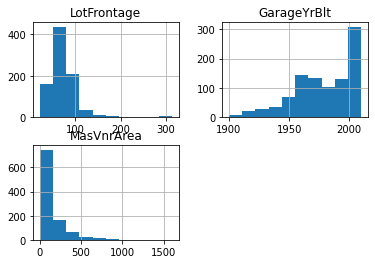

In [27]:
x_train[['LotFrontage','GarageYrBlt', 'MasVnrArea']].hist();

В горния пример слагаме `;` за да не се отпечата върнатата стойност на `hist()` в notebook-а. Правим го за да е по-прегледно. В Python няма нужда от `;` иначе.

### Обработка на празни стойности (NaN, null values)

По някакъв начин трябва да се отървем от празните стойности. Ето няколко варианта:

- Да премахнем целите редове.
- Да ги заменим със средната стойност или медианата на съответната колона. 
- Да направим ML модел, с който да предвидим колоната с липсващи елементи, на база на останалите колони.

В нашия случай ще ги заменим с 0, защото е подходящо с тези данни. И е най-бързо.

In [28]:
x_train[numeric_column_names] = x_train[numeric_column_names].fillna(0)

C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Не обръщайте внимание на warning-а. В този случай е ОК и когато говорим за pandas по-натам ще стане по-ясно защо се случва. Може да намерите хубав tutorial по въпроса тук:

https://www.dataquest.io/blog/settingwithcopywarning/

In [29]:
x_train[numeric_column_names].isnull().sum(axis=0).value_counts()

0    36
dtype: int64

### Да потренираме отново...



**third time's a charm**

Proverb definition:<br>
> One is sure to succeed at a task or event on the third try.
>
> May jokingly be extended to fourth, fifth or higher numbers if success is not achieved on the third try.



In [30]:
regressor.fit(x_train[numeric_column_names], y_train)

LinearRegression()

Успех!


Следва да видим какво е научил:

In [31]:
regressor.score(x_train[numeric_column_names], y_train)

0.7981263665303393

Някакво число. При максимум 1 - не е зле.

Все пак, какво предсказва? Нека да видим как са разпределени предвижданията:

[ 94546.59021575 319548.43264951 140270.63909418 224453.01768405
 236313.23539591 164261.63064394  86677.32797052 254333.97137667]


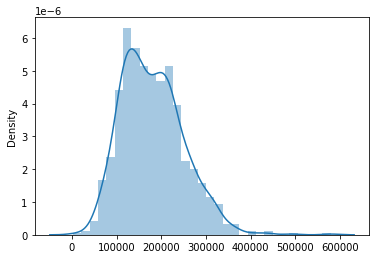

In [32]:
predictions = regressor.predict(x_train[numeric_column_names])

print(predictions[:8])

sns.distplot(predictions);

Може да видим и как е разпределена грешката спрямо стойностите, които трябва да предвидим:

In [33]:
differences = (predictions - y_train).round(0)
print(differences[:8])

Id
128      7547.0
878    -30452.0
880      3771.0
163      4453.0
1181   -13687.0
853       262.0
77     -49073.0
603     34334.0
Name: SalePrice, dtype: float64


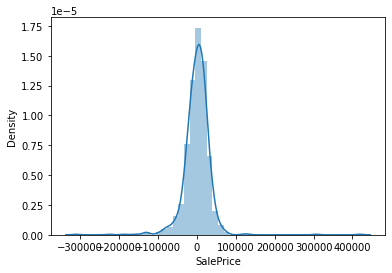

In [34]:
sns.distplot(differences);

Може да видим отклоненията между това, което сме предвидили и резултата, който е трябвало да познаем:

In [35]:
1 - predictions / y_train

Id
128    -0.086742
878     0.087004
880    -0.027624
163    -0.020241
1181    0.054747
          ...   
1114   -0.025753
796    -0.112036
832    -0.006137
79      0.216790
57     -0.325502
Name: SalePrice, Length: 1022, dtype: float64

`predictions / y_train` ще бъде 1 ако сме познали съвсем точно. `1 - predictions / y_train` ще ни върне отклонението в процент.

Може да начертаем същото нещо на диаграма:

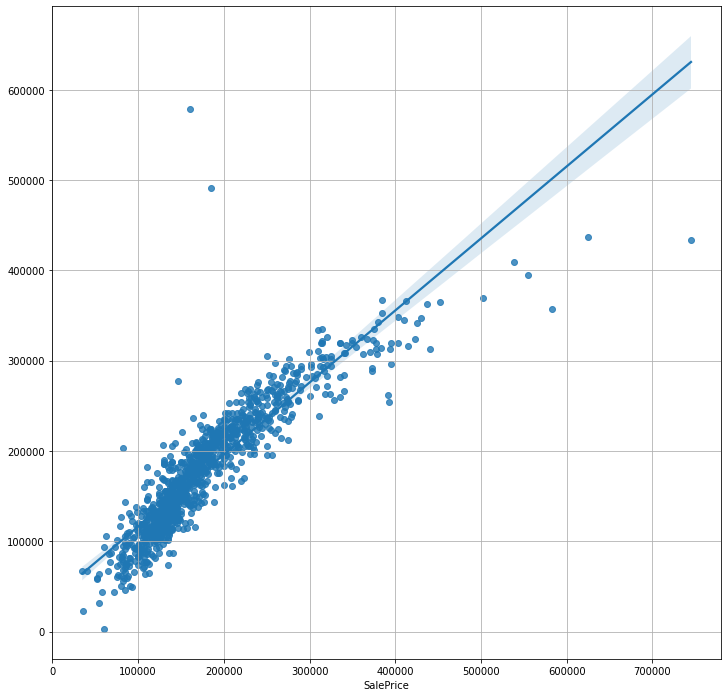

In [36]:
plt.figure(figsize=(12,12))
sns.regplot(y_train, predictions)
plt.grid(True)
plt.show()

По x имаме оригиналната цена, а по y – нашето предвиждане. Ако моделът ни познаваше съвсем точно, всички точки щяха да лежат на правата. Тук може да видим разликите грешката, която правим.

Нека да пробваме с тест сета:

In [37]:
x_test[numeric_column_names].isnull().sum().sort_values(ascending=False)[:4]

LotFrontage    88
GarageYrBlt    32
MasVnrArea      4
YrSold          0
dtype: int64

In [38]:
x_test[numeric_column_names] = x_test[numeric_column_names].fillna(0)

C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


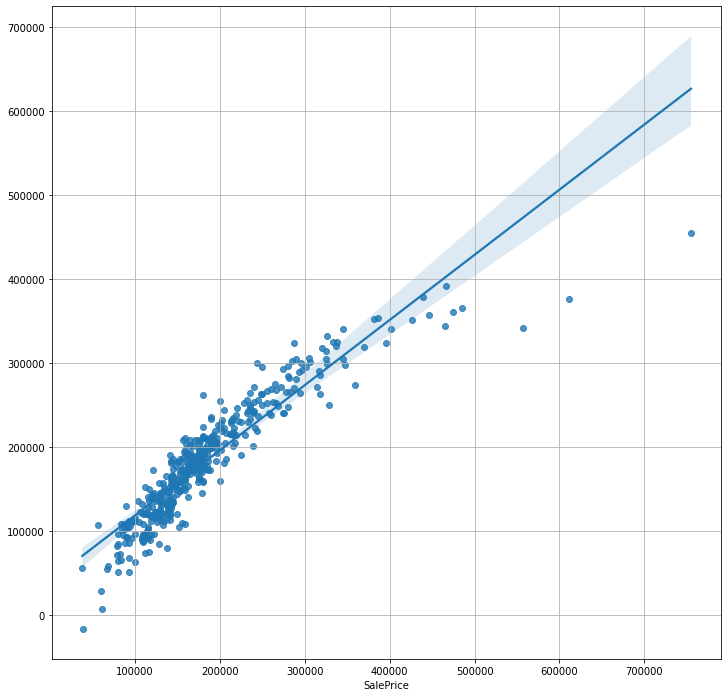

In [39]:
predictions_test = regressor.predict(x_test[numeric_column_names])
plt.figure(figsize=(12,12))
sns.regplot(y_test, predictions_test)
plt.grid(True)
plt.show()

In [40]:
print("score for test:", regressor.score(x_test[numeric_column_names], y_test))

score for test: 0.841202121302285


In [41]:
y_test - predictions_test

Id
479      5382.377918
1129    -2325.205851
385    -14341.154261
1123    37918.467438
1217   -40212.464529
            ...     
648    -14056.862212
184    -23378.329871
800     10477.722516
365     -9039.899706
1175    37648.816435
Name: SalePrice, Length: 438, dtype: float64

In [42]:
deviation = 1 - predictions_test / y_test
deviation[:8]

Id
479     0.018122
1129   -0.010815
385    -0.059755
1123    0.338558
1217   -0.359040
1426   -0.134347
1419    0.051172
19     -0.007233
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

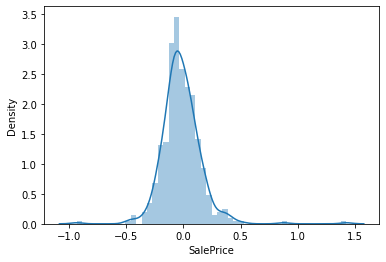

In [43]:
sns.distplot(deviation)

Какво научи модела? Теглата (weights) на всеки един от атрибутите. Нека го визуализираме:

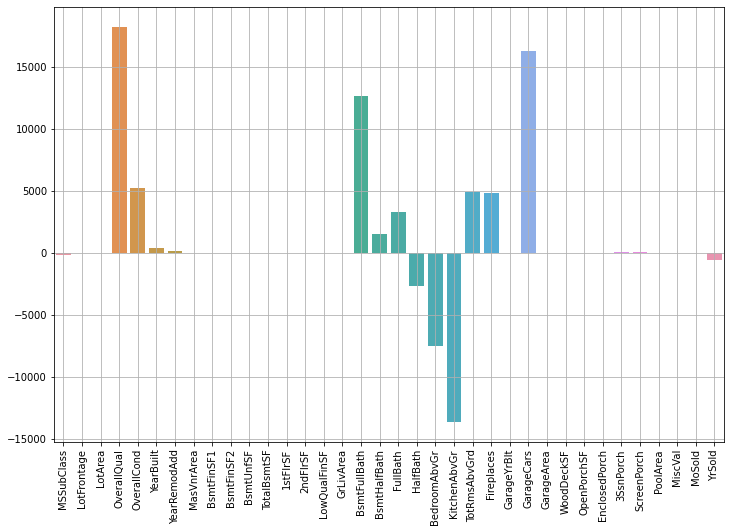

In [44]:
plt.figure(figsize=(12,8))
barplot = sns.barplot(x=numeric_column_names, y=regressor.coef_, orient='vertical')
plt.setp(barplot.get_xticklabels(), rotation=90); plt.grid(True);

Тук може да видим някои интересни неща – олоните `OverallQual` и `BsmtFullBath` имат много голяма стойност. Също, наличието на гараж (`GarageCars`) добавя около 16 000 към цената на апартамента.

В крайна сметка, линейната регресия е просто линейно уравнение с определени коефициенти (тези горе). Може да ги видим в самия регресор:

In [45]:
print(regressor.intercept_)
print(regressor.coef_)

55884.027121245585
[-1.74092382e+02 -1.59334956e+01  3.90604746e-01  1.82477174e+04
  5.21657989e+03  3.75326569e+02  1.36580705e+02  2.17291147e+01
  6.20814805e+00  7.67033291e-03 -6.04172067e-01  5.61164632e+00
  1.99827845e+01  2.17552995e+01 -2.43299134e+01  1.74081705e+01
  1.26936626e+04  1.50351700e+03  3.33729642e+03 -2.70834376e+03
 -7.47762034e+03 -1.36774474e+04  4.95468307e+03  4.80689715e+03
 -1.46397401e+01  1.62721482e+04  6.62093154e+00  3.00251352e+01
  3.95602564e+00  3.05792346e+01  4.55257238e+01  7.31855496e+01
 -6.40235362e+00 -2.58236600e+00  2.66355805e+01 -5.50741893e+02]


Моделът в момента:

цена = 56000 + 17000 \* _OverallQual_ + 16000 \* _GarageCars_ + 12000 \* _BsmtFullBath_ - 14000 \* _KitchenAbvGr_

$y = a_0 + a_1 * x_1 + a_2 * x_2 ... a_n * x_n$

In [46]:
print(regressor.intercept_, " + ",)
list(zip(regressor.coef_, "*"*len(regressor.coef_), numeric_column_names, ))

55884.027121245585  + 


[(-174.09238201320574, '*', 'MSSubClass'),
 (-15.933495614914387, '*', 'LotFrontage'),
 (0.3906047456581882, '*', 'LotArea'),
 (18247.71740753041, '*', 'OverallQual'),
 (5216.579894172018, '*', 'OverallCond'),
 (375.3265694257525, '*', 'YearBuilt'),
 (136.58070545802556, '*', 'YearRemodAdd'),
 (21.72911466906334, '*', 'MasVnrArea'),
 (6.208148052077907, '*', 'BsmtFinSF1'),
 (0.0076703329135211955, '*', 'BsmtFinSF2'),
 (-0.6041720669081425, '*', 'BsmtUnfSF'),
 (5.611646316768264, '*', 'TotalBsmtSF'),
 (19.982784462854717, '*', '1stFlrSF'),
 (21.75529948130274, '*', '2ndFlrSF'),
 (-24.3299134054917, '*', 'LowQualFinSF'),
 (17.408170534355722, '*', 'GrLivArea'),
 (12693.66263196833, '*', 'BsmtFullBath'),
 (1503.5170040006765, '*', 'BsmtHalfBath'),
 (3337.2964235028485, '*', 'FullBath'),
 (-2708.3437562697227, '*', 'HalfBath'),
 (-7477.620342121199, '*', 'BedroomAbvGr'),
 (-13677.447367546763, '*', 'KitchenAbvGr'),
 (4954.683072214145, '*', 'TotRmsAbvGrd'),
 (4806.897153734323, '*', 'Firep

## До тук:

* Разделихме данните на тренировъчно и тестово множество.
* Взехме само числовите колони.
* Изчистихме (земенихме с 0) празните стойности.
* Натренирахме регресор.
* Изчислихме му резултата - за обучение: 0.798 за тест: 0.8412021
* Определихме, че моделът не пренагажда - генерализира добре. Следователно може да бъде използван по-сложен модел.
* Използваните от модела характеристики не изглеждат интуитивно оптимални.
* Разгледахме разликите в предвижданията на цените за тренировъчното и тестовото множество.
* Разгледахме теглата на характеристиките.

## Следва

* Усложняване на модела – вадене на още характеристики от данните.

In [47]:
pd.options.display.max_rows = 10
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

### Скалиране на данните 

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train[numeric_column_names])

x_train_scaled = pd.DataFrame(scaler.transform(x_train[numeric_column_names]), columns = numeric_column_names)
x_test_scaled = pd.DataFrame(scaler.transform(x_test[numeric_column_names]), columns = numeric_column_names)

In [49]:
x_train_scaled.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.225970,0.186695,0.044102,0.509173,0.506570,0.720915,0.578180,0.065627,0.078599,0.030892,0.266501,0.173965,0.183178,0.168656,0.009661,0.207284,0.202055,0.027886,0.525440,0.183464,0.356654,0.349641,0.320228,0.202544,0.937230,0.444227,0.337105,0.107022,0.087825,0.067758,0.007745,0.030793,0.004662,0.004708,0.479808,0.457436
std,0.261272,0.113196,0.053027,0.171749,0.156629,0.219297,0.345627,0.113585,0.082287,0.105250,0.206715,0.073255,0.090755,0.211830,0.084342,0.101418,0.258121,0.116911,0.182945,0.247120,0.105550,0.076342,0.149711,0.214214,0.210763,0.183344,0.149939,0.146645,0.125954,0.185525,0.064628,0.115465,0.061336,0.040469,0.248307,0.333449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.130990,0.029280,0.375000,0.428571,0.594203,0.266667,0.000000,0.000000,0.000000,0.106479,0.130278,0.119444,0.000000,0.000000,0.132062,0.000000,0.000000,0.333333,0.000000,0.250000,0.333333,0.181818,0.000000,0.974627,0.250000,0.238364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272727,0.250000
50%,0.176471,0.201278,0.038536,0.500000,0.428571,0.728261,0.725000,0.000000,0.067417,0.000000,0.225267,0.162848,0.163889,0.000000,0.000000,0.197540,0.000000,0.000000,0.666667,0.000000,0.375000,0.333333,0.272727,0.333333,0.983582,0.500000,0.338505,0.000000,0.047532,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000
75%,0.294118,0.252396,0.048218,0.625000,0.571429,0.934783,0.900000,0.105000,0.127525,0.000000,0.377845,0.212725,0.235764,0.353027,0.000000,0.259032,0.500000,0.000000,0.666667,0.500000,0.375000,0.333333,0.363636,0.333333,0.995522,0.500000,0.406206,0.196033,0.127971,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
regressor_scaled = LinearRegression()
regressor_scaled.fit(x_train_scaled, y_train)

LinearRegression()

In [51]:
print("train score: ", regressor_scaled.score(x_train_scaled, y_train))
print("test score: ", regressor_scaled.score(x_test_scaled, y_test))

train score:  0.7981264951226594
test score:  0.8411998684368274


Резултатът се запазва, но пък сега данните ни са в еднакъв диапазон.

### Категорийни данни 

In [52]:
categorical_columns = train.dtypes[train.dtypes == 'object'].index
print(categorical_columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


Би било добре.... да разгледаме какво съдържат всички колони, но... 

![какво е ML](https://imgs.xkcd.com/comics/machine_learning.png)

### Как да използваме данните от останалите колони? 

Hint: Трябва да ги умножаваме с тегла – трябва да са числови стойности, а не низове.

Може да ползваме трансформатора [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Той ще замени замени всеки уникален низ с число.

In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])

print("Learned classes:", le.classes_)

capitals_list = ["tokyo", "tokyo", "paris"]

print("transofrmed:", capitals_list, " to:", le.transform(["tokyo", "tokyo", "paris"])) 
print("inverse:", [2, 2, 1, 0], " to:", le.inverse_transform([2, 2, 1, 0]))

Learned classes: ['amsterdam' 'paris' 'tokyo']
transofrmed: ['tokyo', 'tokyo', 'paris']  to: [2 2 1]
inverse: [2, 2, 1, 0]  to: ['tokyo' 'tokyo' 'paris' 'amsterdam']


Тук обаче имаме проблем.

Ако теглото за столица е 4. Тогава Амстердам ще има стойност `4 * 0 = 0`, а Париж `4 * 1 = 4`.

Тук може да ни помогне трансформатора [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). Той ще създаде по една колона за всяка стойност, която ще бъде `0` или `1` спрямо дали колоната има тази стойност или не:

In [66]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

print("Categories: ", enc.categories_)

Categories:  [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]


In [67]:
enc.transform([['Female', 1], ['Male', 4]]).toarray()

array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [68]:
enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

array([['Male', 1],
       [None, 2]], dtype=object)

За чистота първо ще превирънем всички низови променливи в числови с помощта на LabelEncoder. Той обаче работи само с 1 колона. Трябва да ги завъртим в цикъл за всички колони.

In [73]:
train = train.fillna("")
encoders = {col: LabelEncoder().fit(train[col]) for col in categorical_columns}

print(encoders['MSZoning'].classes_)
print(encoders['Street'].classes_)

['C (all)' 'FV' 'RH' 'RL' 'RM']
['Grvl' 'Pave']


Сега ще променим низовете към новите идентификатори:

In [74]:
def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

train_encoded = encode_categorical(train, categorical_columns, encoders)

pd.options.display.max_columns=12
train_encoded.head(8)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,...,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,
1,3,1,0,3,3,0,...,2,0,0,0,8,4
2,3,1,0,3,3,0,...,2,0,0,0,8,4
3,3,1,0,0,3,0,...,2,0,0,0,8,4
4,3,1,0,0,3,0,...,2,0,0,0,8,0
5,3,1,0,0,3,0,...,2,0,0,0,8,4
6,3,1,0,0,3,0,...,2,0,3,3,8,4
7,3,1,0,3,3,0,...,2,0,0,0,8,4
8,3,1,0,0,3,0,...,2,0,0,3,8,4


И сега в one-hot:

In [76]:
one_hot_encoder = OneHotEncoder().fit(train_encoded)

print(one_hot_encoder.transform(train_encoded[:10]).todense())
print(one_hot_encoder.transform(train_encoded).shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(1460, 268)


### Да натренираме... регресор само с тези данни

In [77]:
from sklearn.linear_model import LinearRegression 

one_hot_x_train = one_hot_encoder.transform(encode_categorical(x_train[categorical_columns], categorical_columns, encoders))

cat_regression = LinearRegression().fit(one_hot_x_train, y_train)
print("train score: ", cat_regression.score(one_hot_x_train, y_train))

one_hot_x_test = one_hot_encoder.transform(encode_categorical(x_test[categorical_columns], categorical_columns, encoders))
print("test score: ", cat_regression.score(one_hot_x_test, y_test))

train score:  0.8770468421978386
test score:  0.7430330248654301


In [78]:
x_train[numeric_column_names].shape

(1022, 36)

Предишните резултати за обучение: 0.798 за тест: 0.841

Новите са: 0.877 и 0.743

Този модел овърфитва, но пак има стойност. Можем да съединим характеристиките в общ модел.

In [80]:
x_train[numeric_column_names].shape, one_hot_x_train.shape

((1022, 36), (1022, 268))

#### Забележка 

One hot encoding може да се прави и с [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) метода на pandas. За да се използва този метод обаче, ще трябват някои допълнителни трансформации. 

**NB**: One-hot varaiables = dummy variables = indicator variables

In [81]:
pd.get_dummies(x_train[categorical_columns]).head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,
128,0,0,0,0,1,0,...,0,0,0,0,1,0
878,0,0,0,1,0,0,...,0,0,0,0,1,0
880,0,0,0,1,0,0,...,0,0,0,0,1,0
163,0,0,0,1,0,0,...,0,0,0,0,0,1
1181,0,0,0,1,0,0,...,0,0,0,0,1,0


Да се върнем на съединяването на данните:

In [82]:
new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[numeric_column_names]], axis=1)
new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test[numeric_column_names]], axis=1)
print(new_x_train.shape, new_x_test.shape)

(1022, 304) (438, 304)


In [83]:
# new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train_scaled], axis=1)
# new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test_scaled], axis=1)
# print(new_x_train.shape, new_x_test.shape)

In [84]:
pd.DataFrame(new_x_train).describe()

,0,1,2,3,4,5,...,298,299,300,301,302,303
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,...,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.007828,0.050881,0.010763,0.787671,0.142857,0.003914,...,3.934442,14.780822,3.440313,39.080235,6.277886,2007.829746
std,0.088171,0.219862,0.103237,0.409157,0.350098,0.062469,...,32.831010,55.423160,45.265717,335.892594,2.731375,1.333798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000


### Да потренираме... отново


In [85]:
all_data_lr = LinearRegression().fit(new_x_train, y_train)
print("train score: ", all_data_lr.score(new_x_train, y_train))
print("test score: ", all_data_lr.score(new_x_test, y_test))

train score:  0.9374779030406712
test score:  -240433001.44012934


Новите: 0.937, за тест - отрицателна оценка. Обяснение защо е възможна отрицателна оценка [в stackoverflow](https://stackoverflow.com/questions/23036866/scikit-learn-is-returning-coefficient-of-determination-r2-values-less-than-1) и в [документацията на sclearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html). Накратко, константен модел ще има оценка 0, а оценка под нулата означава, че моделът е по-лош от константния. 

Ще пробваме да подобрим ситуацията с регуларизация. 

In [86]:
from sklearn.linear_model import Ridge

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    all_data_lr = Ridge(alpha = a).fit(new_x_train, y_train)
    print('alpha:', a)
    print(all_data_lr.score(new_x_train, y_train), all_data_lr.score(new_x_test, y_test))
    print()

alpha: 0.01
0.9374607177132871 0.8488214740142933

alpha: 0.1
0.9364454642419521 0.8596282428267922

alpha: 1
0.9227360656014941 0.8824267159987824

alpha: 10
0.8933107135132802 0.8922404784820501

alpha: 100
0.8524424288746798 0.8821692100273288



Новите резултати при alpha= 10:

трениране: 0.8933

тест: 0.8922

Моделът е доста по-добър и генерализира добре. Може и да изтиска още малко ако се търси в диапазона 0.1 до 100 на alpha.

### Още една трансформация (feature engineering)

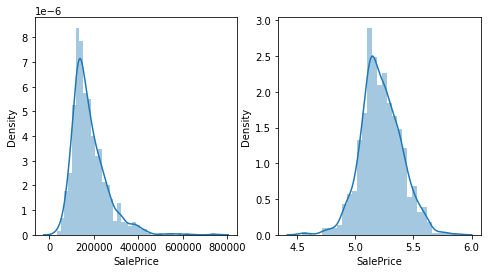

In [89]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.distplot(y_train)
plt.subplot(1, 2, 2)
sns.distplot(np.log10(y_train));

Тук имаше малко магия – първата дистрибуция ила long-tail форма. Понякога като прекараме такава дистрибуция през логаритъм, тя започва да изглежда по-стандартно. В случая (произволно) избрахме логаритъм при основа 10, което свежда нещата до що-годе стандартна дистрибуция.

In [90]:
all_data_lr = LinearRegression().fit(new_x_train, pd.np.log10(y_train))
print(all_data_lr.score(new_x_train, np.log10(y_train)))
print(all_data_lr.score(new_x_test, np.log10(y_test)))

# Предишни резултати: 
# трейн: 0.893310713513
# тест: 0.892240478482

0.9440102727878052
-26622.22324266047


Отново има пренагаждане. Може да пробваме с регуляризация. Нека да потърсим подходящ `alpha` параметър:

In [91]:
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    all_data_lr = Ridge(alpha = alpha).fit(new_x_train, pd.np.log10(y_train))
    print('alpha:', alpha)
    print(all_data_lr.score(new_x_train, pd.np.log10(y_train)), all_data_lr.score(new_x_test, pd.np.log10(y_test)))
    print()

alpha: 0.01
0.9439975012519929 0.8983736949620592

alpha: 0.1
0.943229831718568 0.9059958936362619

alpha: 1
0.9341947544847011 0.9186587324988609

alpha: 10
0.9145728136422795 0.9257768879730854

alpha: 100
0.8856716730211227 0.922058006344062



alpha: 10

0.914572813642

0.925776887973



Хубава статия за още масажиране на данните: 

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook

### Последно - полиномни

Може да ползваме трансформатора `PolynomialFeatures`, за да генерираме всички възможни полиноми от втора степен с входните данни:

In [92]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

poly_features.fit(new_x_train)

poly_x_train = poly_features.transform(new_x_train)
poly_x_test = poly_features.transform(new_x_test)

print(new_x_train.shape)
print(poly_x_train.shape)

(1022, 304)
(1022, 46665)


Нека да видим резултата с различни регуляризации.

In [93]:
for a in [10e6, 10e7, 10e8, 10e9, 10e10]:
    print('alpha:', a)
    all_data_lr = Ridge(alpha=a).fit(poly_x_train, pd.np.log10(y_train))
    print(all_data_lr.score(poly_x_train, pd.np.log10(y_train)), all_data_lr.score(poly_x_test, pd.np.log10(y_test)))
    print()

alpha: 10000000.0


C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.56155e-17): result may not be accurate.
  overwrite_a=False)


0.987828133134003 -0.8459169711608534

alpha: 100000000.0
0.9749803261238896 0.5566869902732761

alpha: 1000000000.0
0.9606070697618985 0.8285642929107262

alpha: 10000000000.0
0.9409678581336217 0.5370210014985528

alpha: 100000000000.0
0.9114683630178015 0.5186623902133037



Този модел прави стабилен overfitting – явно е твърде сложен.

Като правило, когато има повече колони, отколкото редове, това се случва.

### Намерихме модел, да го събмитнем.

In [94]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

def pipeline_data(data):
    _numeric = data[numeric_column_names].fillna(0)
    _categorical = data[categorical_columns].fillna("")
    _encoded = encode_categorical(_categorical, categorical_columns, encoders)
    _one_hot_encoded = one_hot_encoder.transform(_encoded)
    _merged = pd.np.concatenate([_one_hot_encoded.todense(), _numeric], axis=1)
    return _merged

In [95]:
full_x = pipeline_data(train)
full_y = train['SalePrice']

# Fix test set missing data problems
test['MSZoning'].fillna('RL', inplace=True)
test['Utilities'].fillna('AllPub', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)

test_set = pipeline_data(test)

In [96]:
ridge = Ridge(alpha=0.1).fit(full_x, pd.np.log10(full_y))

In [97]:
predictions = 10**ridge.predict(test_set)
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})

In [98]:
predictions_df.head()

,Id,SalePrice
0,1461,120358.057284
1,1462,155362.310396
2,1463,181005.749466
3,1464,201610.093152
4,1465,195592.024893


In [99]:
predictions_df.to_csv("submit_me.csv", index=False)

### Заключения

1. Има ли значение дали правим регресия или класификация?
Ако колоната, която предсказваме съдържа ['скъпа', 'евтина', 'средна']

2. Има ли значение кой модел ползваме - LinearRegression, RandomForest, Neural Network, kNN?

3. Колко кобминации можем да направим за модела?

4. 4 часа разглеждане на данни, чистене и оформяне на pipeline и фичъри. 20 минути трениране и оптимизиране на модели.

### За домашно - прочетете документацията: 

  * http://scikit-learn.org/stable/modules/preprocessing.html
  * https://seaborn.pydata.org/
  * https://pandas.pydata.org/pandas-docs/stable/


### За упражнение:

Изпробвайте Random Forest и kNN (или други) регресори за текущите данни. Подобряват ли се резултатите?